In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

In [3]:
# Function to generate feature plots with KDE
def generate_feature_plots(num_features, X_class_0, X_class_1):
    
    rows = math.ceil(num_features/3)
    if num_features/3 > 0:
        cols = 3
    else:
        cols = num_features%3
    #rows = 2
    #cols = 3
    fig, axes = plt.subplots(figsize=(4*cols, 4*rows), nrows=rows, ncols=cols, squeeze=False)

    color0 = 'blue'
    color1 = 'red'

    for r, row in enumerate(axes):
        for c, axScatter in enumerate(row):
            feature_idx = r * cols + c  # Determine feature index

            if feature_idx >= num_features:  # Skip unused subplots
                axScatter.axis('off')
                continue

            # Extract the selected feature
            feature_class_0 = X_class_0[:, feature_idx]
            feature_class_1 = X_class_1[:, feature_idx]
            x_class_0 = np.arange(len(feature_class_0))
            x_class_1 = np.arange(len(feature_class_1))

            # Scatter plot with customized styling
            axScatter.scatter(x_class_0, feature_class_0, color=color0, alpha=0.6, s=50, edgecolors='black', label="Class 0")
            axScatter.scatter(x_class_1, feature_class_1, color=color1, alpha=0.6, s=50, edgecolors='black', label="Class 1")

            axScatter.ticklabel_format(style='sci', axis='x', scilimits=(0,4))

            axScatter.set_aspect('auto')
            axScatter.set_title(f"Feature {feature_idx + 1}", fontsize=14)

            # Create new axes on the right for histograms
            divider = make_axes_locatable(axScatter)
            axHisty = divider.append_axes("right", 1, pad=0.1, sharey=axScatter)

            # Make the y-axis label of the histogram invisible
            axHisty.yaxis.set_tick_params(labelleft=False)

            # Set histogram bins
            num_bins = 30

            # Plot the histograms with a smooth edge
            axHisty.hist(feature_class_0, bins=num_bins, orientation='horizontal', color=color0, edgecolor='grey', linewidth=1.5, alpha=0.4)
            axHisty.hist(feature_class_1, bins=num_bins, orientation='horizontal', color=color1, edgecolor='grey', linewidth=1.5, alpha=0.4)

    # Adjust the layout to avoid overlap
    plt.tight_layout()
    plt.show()

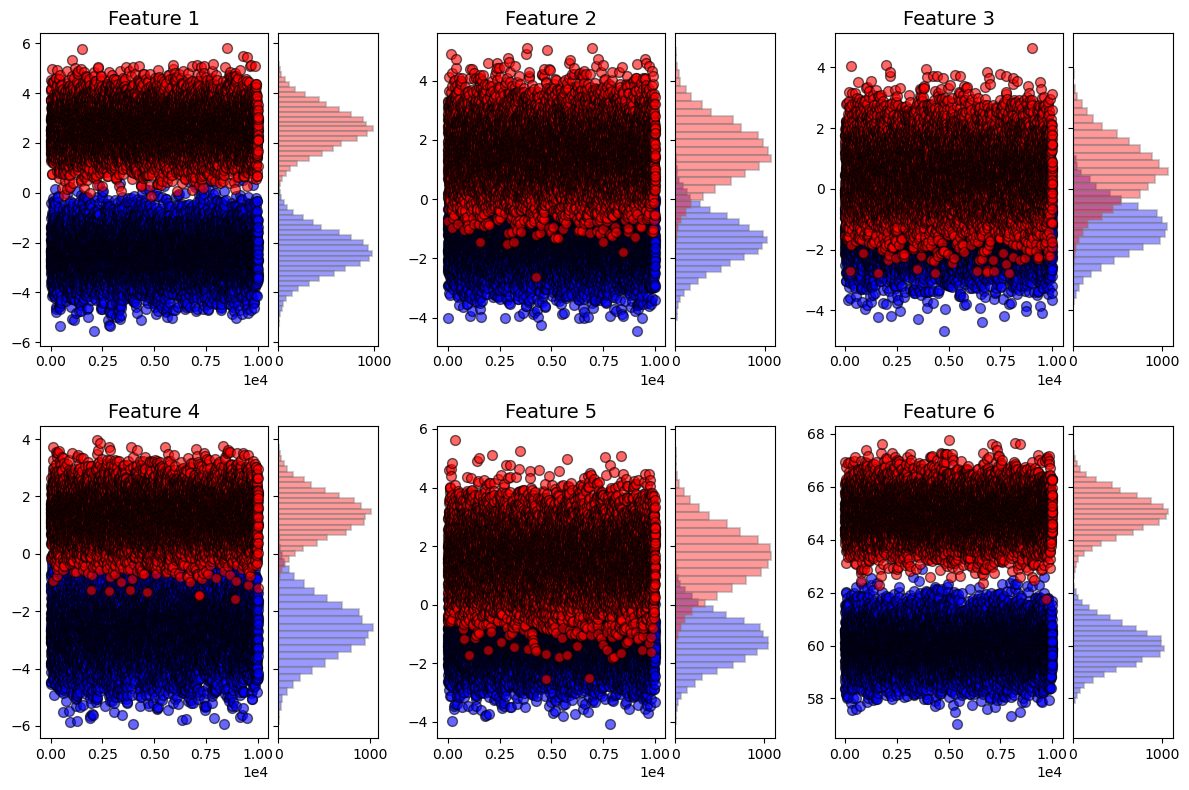

In [4]:
num_samples = 10000
# Run optimization and plot KDE
num_features = 6
#means_class_0 = [-3, -2, -1, 0, 1, 50]  # Specific means for each feature
#means_class_1 = [0, 1, 2, 3, 4, 45]     # Specific means for each feature
means_class_0 = np.random.uniform(-3, 0, size=num_features-1)
means_class_1 = np.random.uniform(0, 3, size=num_features-1)

means_class_0 = np.append(means_class_0, 60)
means_class_1 = np.append(means_class_1, 65)
#means_class_0 = np.append(means_class_0, 45)
#means_class_1 = np.append(means_class_1, 48)
covs_class_0 = np.diag(np.random.uniform(0.5, 1, size=num_features))
covs_class_1 = np.diag(np.random.uniform(0.5, 1, size=num_features))

X_class_0 = np.random.multivariate_normal(means_class_0, covs_class_0, size=num_samples)
X_class_1 = np.random.multivariate_normal(means_class_1, covs_class_1, size=num_samples)

moments_1 = (means_class_0, means_class_1)
moments_2 = (covs_class_0, covs_class_1)

# Plot KDE for features
generate_feature_plots(num_features, X_class_0, X_class_1)


In [5]:
# Gradient calculation for binary cross-entropy loss
def gradient_function(A, x, b):
    """Computes the gradient of binary cross-entropy loss."""
    probabilities = 1 / (1 + np.exp(-A @ x))
    return (1 / len(b)) * A.T @ (probabilities - b)


In [6]:
def sample_data(batch_size, moments_1, moments_2):

    (means_class_0, means_class_1) = moments_1
    (covs_class_0, covs_class_1) = moments_2
    # Sample points from both classes
    X_class_0 = np.random.multivariate_normal(means_class_0, covs_class_0, size=batch_size // 2)
    X_class_1 = np.random.multivariate_normal(means_class_1, covs_class_1, size=batch_size // 2)
    y_class_0 = np.zeros((batch_size // 2, 1))
    y_class_1 = np.ones((batch_size // 2, 1))
    
    X = np.vstack((X_class_0, X_class_1))
    y = np.vstack((y_class_0, y_class_1))

    # Shuffle data
    indices = np.arange(batch_size)
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [12]:
def heavy_ball_friction(xk, xk_minus_1, moments_1, moments_2, num_iterations, alpha, s0, batch_size_init, step_decay):

    # xk = np.random.uniform(-1, 1, (num_features, 1))
    # xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)
    s_k = s0
    s_k_minus_1 = s0
    batch_size = batch_size_init
    X_batch_init, y_batch_init = sample_data(batch_size, moments_1, moments_2)
    X_batch_true_init, y_batch_true_init = sample_data(10000, moments_1, moments_2)
    grad_list = [gradient_function(X_batch_init, xk, y_batch_init)]
    loss_list = [np.mean(-y_batch_init * np.log(1 / (1 + np.exp(-X_batch_init @ xk))) - (1 - y_batch_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_init @ xk))))]
    vel_norms_list = [np.linalg.norm(xk)]
    true_grad_list = [gradient_function(X_batch_true_init, xk, y_batch_true_init)]
    pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]

    for k in range(2, num_iterations + 1):
        # Sample data dynamically
        X_batch_x, y_batch_x = sample_data(batch_size, moments_1, moments_2)
        X_batch_y, y_batch_y = sample_data(batch_size, moments_1, moments_2)
        # Calculate t_k and other parameters
        #t_k = (k - 1) / (alpha - 1)
        if step_decay:
            s_k = s0 / np.sqrt(k)
        
        else:
            s_k = s0

        # Compute gradients
        grad_xk = gradient_function(X_batch_x, xk, y_batch_x)
        #grad_xk_minus_1 = gradient_function(X_batch_x, xk_minus_1, y_batch_x)

        X_batch_true, y_batch_true = sample_data(10000, moments_1, moments_2)

        grad_true_xk = gradient_function(X_batch_true, xk, y_batch_true)

        #alpha_k = 1 - (alpha / k)

        # Calculate yk
        yk = xk + alpha * (xk - xk_minus_1)

        # Update xk+1
        grad_yk = gradient_function(X_batch_y, yk, y_batch_y)
        xk_plus_1 = yk - s_k * grad_yk

        # Record velocity norms and loss
        vel_norms_list.append(np.linalg.norm(xk - xk_minus_1))
        loss = np.mean(-y_batch_x * np.log(1 / (1 + np.exp(-X_batch_x @ xk))) - (1 - y_batch_x) * np.log(1 - 1 / (1 + np.exp(-X_batch_x @ xk))))
        pop_loss = np.mean(-y_batch_true * np.log(1 / (1 + np.exp(-X_batch_true @ xk))) - (1 - y_batch_true) * np.log(1 - 1 / (1 + np.exp(-X_batch_true @ xk))))
        loss_list.append(loss)
        pop_loss_list.append(pop_loss)
        
        grad_list.append(grad_xk)
        true_grad_list.append(grad_true_xk)
        # Update variables for next iteration
        xk_minus_1 = xk
        xk = xk_plus_1
        #s_k_minus_1 = s_k

        batch_size = batch_size_init*(k**2)

        
        print(f"Iteration {k}: Loss = {pop_loss_list[-1]:.4f}, Step Size s_k = {s_k:.6f}")

    return vel_norms_list, loss_list, pop_loss_list, grad_list, true_grad_list


In [23]:
def nesterov_viscous(xk, xk_minus_1, moments_1, moments_2, num_iterations, alpha, s0, batch_size_init, step_decay):
    # Initialize parameters for Gaussian distributions
    # Initialize optimization variables
    # xk = np.random.uniform(-1, 1, (num_features, 1))
    # xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)
    s_k = s0
    s_k_minus_1 = s0
    batch_size = batch_size_init
    X_batch_init, y_batch_init = sample_data(batch_size, moments_1, moments_2)
    X_batch_true_init, y_batch_true_init = sample_data(10000, moments_1, moments_2)
    grad_list = [gradient_function(X_batch_init, xk, y_batch_init)]
    loss_list = [np.mean(-y_batch_init * np.log(1 / (1 + np.exp(-X_batch_init @ xk))) - (1 - y_batch_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_init @ xk))))]
    pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]
    vel_norms_list = [np.linalg.norm(xk)]
    true_grad_list = [gradient_function(X_batch_true_init, xk, y_batch_true_init)]
    xk_list = [xk]

    for k in range(2, num_iterations + 1):
        # Sample data dynamically
        X_batch_x, y_batch_x = sample_data(batch_size, moments_1, moments_2)
        X_batch_y, y_batch_y = sample_data(batch_size, moments_1, moments_2)
        
        # Calculate t_k and other parameters
        t_k = (k - 1) / (alpha - 1)

        if step_decay:
            s_k = s0 / np.sqrt(k)
        else:
            s_k = s0
        #

        # Compute gradients
        grad_xk = gradient_function(X_batch_x, xk, y_batch_x)
        #grad_xk_minus_1 = gradient_function(X_batch, xk_minus_1, y_batch)

        X_batch_true, y_batch_true = sample_data(10000, moments_1, moments_2)

        grad_true_xk = gradient_function(X_batch_true, xk, y_batch_true)

        alpha_k = 1 - (alpha / k)
        #alpha_k = alpha / k
        # Calculate yk
        yk = xk + alpha_k * (xk - xk_minus_1)

        # Update xk+1
        grad_yk = gradient_function(X_batch_y, yk, y_batch_y)
        xk_plus_1 = yk - s_k * grad_yk

        # Record velocity norms and loss
        vel_norms_list.append(np.linalg.norm(xk - xk_minus_1))
        loss = np.mean(-y_batch_x * np.log(1 / (1 + np.exp(-X_batch_x @ xk))) - (1 - y_batch_x) * np.log(1 - 1 / (1 + np.exp(-X_batch_x @ xk))))
        loss_list.append(loss)
        pop_loss = np.mean(-y_batch_true * np.log(1 / (1 + np.exp(-X_batch_true @ xk))) - (1 - y_batch_true) * np.log(1 - 1 / (1 + np.exp(-X_batch_true @ xk))))
        pop_loss_list.append(pop_loss)

        grad_list.append(grad_xk)
        true_grad_list.append(grad_true_xk)
        xk_list.append(xk)
        # Update variables for next iteration
        xk_minus_1 = xk
        xk = xk_plus_1
        #s_k_minus_1 = s_k

        batch_size = batch_size_init*(k**2)

        
        print(f"Iteration {k}: Loss = {pop_loss_list[-1]:.4f}, Step Size s_k = {s_k:.6f}")

    return vel_norms_list, loss_list, pop_loss_list, grad_list, true_grad_list, xk_list
    

In [14]:
def calculate_hessian_eigenvalues(X_batch, y_batch, xk):
    """
    Calculate the eigenvalues of the Hessian matrix of the logistic regression loss function.
    
    Parameters:
    - X_batch: Feature matrix for the batch (N x d).
    - y_batch: Labels for the batch (N x 1).
    - xk: Current model parameters (d x 1).
    
    Returns:
    - eigenvalues: Eigenvalues of the Hessian matrix.
    """
    # Sigmoid function
    sigmoid = lambda z: 1 / (1 + np.exp(-z))
    
    # Predicted probabilities
    logits = X_batch @ xk
    probs = sigmoid(logits)
    
    # Diagonal matrix of weights (p * (1 - p))
    W = np.diag((probs * (1 - probs)).flatten())
    
    # Hessian matrix (X^T W X)
    H = X_batch.T @ W @ X_batch
    
    # Compute eigenvalues of the Hessian
    eigenvalues = np.linalg.eigvals(H)

    max_ev = np.max(eigenvalues)
    min_ev = np.min(eigenvalues)
    #print("min_ev", min_ev)
    
    return max_ev, min_ev

In [15]:
# # Custom optimization function
# def inertial_hessian(xk, xk_minus_1, moments_1, moments_2, num_iterations, alpha, s0, beta, batch_size_init, step_decay):
#     # Initialize parameters for Gaussian distributions
#     # Initialize optimization variables
    
#     s_k = s0
#     s_k_minus_1 = s0
#     beta_k = beta
#     beta_k_minus_1 = beta
#     batch_size = batch_size_init
#     X_batch_init, y_batch_init = sample_data(batch_size, moments_1, moments_2)
#     X_batch_true_init, y_batch_true_init = sample_data(10000, moments_1, moments_2)
#     grad_list = [gradient_function(X_batch_init, xk, y_batch_init)]
#     loss_list = [np.mean(-y_batch_init * np.log(1 / (1 + np.exp(-X_batch_init @ xk))) - (1 - y_batch_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_init @ xk))))]
#     pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]
#     vel_norms_list = [np.linalg.norm(xk)]
#     true_grad_list = [gradient_function(X_batch_true_init, xk, y_batch_true_init)]
#     xk_list = [xk]
#     exp_param_list = []

#     for k in range(2, num_iterations + 1):
#         # Sample data dynamically
#         X_batch, y_batch = sample_data(batch_size, moments_1, moments_2)
        
#         # Calculate t_k and other parameters
#         t_k = (k - 1) / (alpha - 1)
#         if step_decay:
#             s_k = s0 / np.sqrt(k)
#             beta_k = np.sqrt(s_k) / 4
#         else:
#             s_k = s0
#             beta_k = beta

#         # Compute gradients
#         grad_xk = gradient_function(X_batch, xk, y_batch)
#         grad_xk_minus_1 = gradient_function(X_batch, xk_minus_1, y_batch)

#         X_batch_true, y_batch_true = sample_data(10000, moments_1, moments_2)

#         grad_true_xk = gradient_function(X_batch_true, xk, y_batch_true)

#         alpha_k = 1 - (alpha / k)

#         #alpha_k = (alpha / k)

#         #Calculate yk
#         yk = (
#             xk
#             + alpha_k * (xk - xk_minus_1)
#             -  (beta_k*np.sqrt(s_k) * grad_xk - beta_k_minus_1 * np.sqrt(s_k_minus_1)*grad_xk_minus_1)
#             - (beta_k_minus_1 * np.sqrt(s_k_minus_1) / k) * grad_xk_minus_1
#         )

#         # yk = (
#         #     xk
#         #     + alpha_k * (xk - xk_minus_1)
#         #     -  (beta_k*np.sqrt(s_k) * grad_xk - beta_k * np.sqrt(s_k)*grad_xk_minus_1)
#         #     - (beta_k * np.sqrt(s_k) / k) * grad_xk_minus_1
#         # )

#         max_ev = calculate_hessian_eigenvalues(X_batch_true, y_batch_true, xk)

#         exp_param_list.append(beta**2 * max_ev - 4* (1 + (beta)/t_k))

#         # Update xk+1
#         grad_yk = gradient_function(X_batch, yk, y_batch)
#         xk_plus_1 = yk - s_k * grad_yk

#         # Record velocity norms and loss
#         vel_norms_list.append(np.linalg.norm(xk - xk_minus_1))
#         loss = np.mean(-y_batch * np.log(1 / (1 + np.exp(-X_batch @ xk))) - (1 - y_batch) * np.log(1 - 1 / (1 + np.exp(-X_batch @ xk))))
#         #e_vals = calculate_hessian_eigenvalues(X_batch, y_batch, xk)
#         #print("Eigenvals: ", e_vals)
#         pop_loss = np.mean(-y_batch_true * np.log(1 / (1 + np.exp(-X_batch_true @ xk))) - (1 - y_batch_true) * np.log(1 - 1 / (1 + np.exp(-X_batch_true @ xk))))
#         pop_loss_list.append(pop_loss)
#         loss_list.append(loss)
        
#         grad_list.append(grad_xk)
#         true_grad_list.append(grad_true_xk)
#         xk_list.append(xk)
#         # Update variables for next iteration
#         xk_minus_1 = xk
#         xk = xk_plus_1
#         s_k_minus_1 = s_k
#         beta_k_minus_1 = beta_k

#         batch_size += 8

        
#         print(f"Iteration {k}: Loss = {pop_loss_list[-1]:.4f}, Step Size s_k = {s_k:.6f}")

#     return vel_norms_list, loss_list, pop_loss_list, grad_list, true_grad_list, xk_list, exp_param_list


In [24]:
# Custom optimization function
def inertial_hessian(xk, xk_minus_1, moments_1, moments_2, num_iterations, alpha, s0, beta, batch_size_init, step_decay):
    # Initialize parameters for Gaussian distributions
    # Initialize optimization variables
    
    s_k = s0
    s_k_minus_1 = s0
    beta_k = beta
    beta_k_minus_1 = beta
    batch_size = batch_size_init
    X_batch_init, y_batch_init = sample_data(batch_size, moments_1, moments_2)
    X_batch_true_init, y_batch_true_init = sample_data(10000, moments_1, moments_2)
    grad_list = [gradient_function(X_batch_init, xk, y_batch_init)]
    loss_list = [np.mean(-y_batch_init * np.log(1 / (1 + np.exp(-X_batch_init @ xk))) - (1 - y_batch_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_init @ xk))))]
    pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]
    vel_norms_list = [np.linalg.norm(xk)]
    true_grad_list = [gradient_function(X_batch_true_init, xk, y_batch_true_init)]
    xk_list = [xk]
    exp_param_list = []
    xi2_param_list = []

    for k in range(2, num_iterations + 1):
        # Sample data dynamically
        X_batch_x, y_batch_x = sample_data(batch_size, moments_1, moments_2)
        X_batch_x_minus_1, y_batch_x_minus_1 = sample_data(batch_size, moments_1, moments_2)
        X_batch_y, y_batch_y = sample_data(batch_size, moments_1, moments_2)

        
        # Calculate t_k and other parameters
        t_k = (k - 1) / (alpha - 1)
        if step_decay:
            s_k = s0 / np.sqrt(k)
            beta_k = np.sqrt(s_k) / 2
        else:
            s_k = s0
            beta_k = beta

        # Compute gradients
        grad_xk = gradient_function(X_batch_x, xk, y_batch_x)
        grad_xk_minus_1 = gradient_function(X_batch_x_minus_1, xk_minus_1, y_batch_x_minus_1)

        X_batch_true, y_batch_true = sample_data(10000, moments_1, moments_2)

        grad_true_xk = gradient_function(X_batch_true, xk, y_batch_true)

        alpha_k = 1 - (alpha / k)

        #alpha_k = (alpha / k)

        #Calculate yk
        yk = (
            xk
            + alpha_k * (xk - xk_minus_1)
            -  (beta_k*np.sqrt(s_k) * grad_xk - beta_k_minus_1 * np.sqrt(s_k_minus_1)*grad_xk_minus_1)
            - (beta_k_minus_1 * np.sqrt(s_k_minus_1) / k) * grad_xk_minus_1
        )

        # yk = (
        #     xk
        #     + alpha_k * (xk - xk_minus_1)
        #     -  (beta_k*np.sqrt(s_k) * grad_xk - beta_k * np.sqrt(s_k)*grad_xk_minus_1)
        #     - (beta_k * np.sqrt(s_k) / k) * grad_xk_minus_1
        # )

        #max_ev, min_ev = calculate_hessian_eigenvalues(X_batch_true, y_batch_true, xk)
        #print("Max EV :", max_ev)
        #print("Min EV :", min_ev)

        #exp_param_list.append((np.sqrt((beta**2 * max_ev**2) - 4*max_ev*(1 + (beta)/t_k)) + beta * max_ev))
        #xi2_param_list.append((beta**2 * max_ev**2) - 4*max_ev*(1 + (beta)/t_k))

        # Update xk+1
        grad_yk = gradient_function(X_batch_y, yk, y_batch_y)
        xk_plus_1 = yk - s_k * grad_yk

        # Record velocity norms and loss
        vel_norms_list.append(np.linalg.norm(xk - xk_minus_1))
        loss = np.mean(-y_batch_x * np.log(1 / (1 + np.exp(-X_batch_x @ xk))) - (1 - y_batch_x) * np.log(1 - 1 / (1 + np.exp(-X_batch_x @ xk))))
        #e_vals = calculate_hessian_eigenvalues(X_batch, y_batch, xk)
        #print("Eigenvals: ", e_vals)
        pop_loss = np.mean(-y_batch_true * np.log(1 / (1 + np.exp(-X_batch_true @ xk))) - (1 - y_batch_true) * np.log(1 - 1 / (1 + np.exp(-X_batch_true @ xk))))
        pop_loss_list.append(pop_loss)
        loss_list.append(loss)
        
        grad_list.append(grad_xk)
        true_grad_list.append(grad_true_xk)
        xk_list.append(xk)
        # Update variables for next iteration
        xk_minus_1 = xk
        xk = xk_plus_1
        s_k_minus_1 = s_k
        beta_k_minus_1 = beta_k

        batch_size = batch_size_init*(k**2)

        
        print(f"Iteration {k}: Loss = {pop_loss_list[-1]:.4f}, Step Size s_k = {s_k:.6f}")

    return vel_norms_list, loss_list, pop_loss_list, grad_list, true_grad_list, xk_list, exp_param_list, xi2_param_list


In [11]:
# xk = np.random.uniform(-1, 1, (num_features, 1))
# xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)

In [33]:
xk = np.random.uniform(-1, 1, (num_features, 1))
xk_minus_1 = np.random.uniform(-1, 1, (num_features, 1))

In [28]:
s0 = 0.01
beta = 0.05
alpha_h = 0.1
alpha = 3.1
iterations = 300
bs_init = 2

In [34]:
xk = np.random.uniform(-1, 1, (num_features, 1))
xk_minus_1 = np.random.uniform(-1, 1, (num_features, 1))
# Run AVD
vel_norms_hbf, losses_hbf, pop_losses_hbf, grads_hbf, true_grads_hbf = heavy_ball_friction(xk, xk_minus_1, moments_1, moments_2, num_iterations=iterations, alpha=alpha_h, s0=s0, batch_size_init=bs_init, step_decay=True)

/tmp/ipykernel_98681/3081434024.py:11: RuntimeWarning: divide by zero encountered in log
  loss_list = [np.mean(-y_batch_init * np.log(1 / (1 + np.exp(-X_batch_init @ xk))) - (1 - y_batch_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_init @ xk))))]
/tmp/ipykernel_98681/3081434024.py:11: RuntimeWarning: invalid value encountered in multiply
  loss_list = [np.mean(-y_batch_init * np.log(1 / (1 + np.exp(-X_batch_init @ xk))) - (1 - y_batch_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_init @ xk))))]
/tmp/ipykernel_98681/3081434024.py:14: RuntimeWarning: divide by zero encountered in log
  pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]
/tmp/ipykernel_98681/3081434024.py:14: RuntimeWarning: invalid value encountered in multiply
  pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1

Iteration 2: Loss = nan, Step Size s_k = 0.007071
Iteration 3: Loss = nan, Step Size s_k = 0.005774
Iteration 4: Loss = nan, Step Size s_k = 0.005000
Iteration 5: Loss = 8.3829, Step Size s_k = 0.004472
Iteration 6: Loss = 3.8375, Step Size s_k = 0.004082
Iteration 7: Loss = 0.3034, Step Size s_k = 0.003780
Iteration 8: Loss = 0.0494, Step Size s_k = 0.003536
Iteration 9: Loss = 0.0455, Step Size s_k = 0.003333
Iteration 10: Loss = 0.0461, Step Size s_k = 0.003162
Iteration 11: Loss = 0.0466, Step Size s_k = 0.003015
Iteration 12: Loss = 0.0461, Step Size s_k = 0.002887
Iteration 13: Loss = 0.0449, Step Size s_k = 0.002774
Iteration 14: Loss = 0.0475, Step Size s_k = 0.002673
Iteration 15: Loss = 0.0450, Step Size s_k = 0.002582
Iteration 16: Loss = 0.0449, Step Size s_k = 0.002500
Iteration 17: Loss = 0.0450, Step Size s_k = 0.002425
Iteration 18: Loss = 0.0451, Step Size s_k = 0.002357
Iteration 19: Loss = 0.0465, Step Size s_k = 0.002294
Iteration 20: Loss = 0.0455, Step Size s_k = 

In [30]:
xk = np.random.uniform(-1, 1, (num_features, 1))
xk_minus_1 = np.random.uniform(-1, 1, (num_features, 1))
# Run AVD
vel_norms_fista, losses_fista, pop_losses_fista, grads_fista, true_grads_fista, xks_fista = nesterov_viscous(xk, xk_minus_1, moments_1, moments_2, num_iterations=iterations, alpha=alpha, s0=s0, batch_size_init=bs_init, step_decay=True)

Iteration 2: Loss = nan, Step Size s_k = 0.007071
Iteration 3: Loss = 0.8383, Step Size s_k = 0.005774
Iteration 4: Loss = 2.1404, Step Size s_k = 0.005000
Iteration 5: Loss = 0.9017, Step Size s_k = 0.004472


/tmp/ipykernel_98681/3621629719.py:13: RuntimeWarning: divide by zero encountered in log
  pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]
/tmp/ipykernel_98681/3621629719.py:13: RuntimeWarning: invalid value encountered in multiply
  pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]
/tmp/ipykernel_98681/3621629719.py:53: RuntimeWarning: divide by zero encountered in log
  pop_loss = np.mean(-y_batch_true * np.log(1 / (1 + np.exp(-X_batch_true @ xk))) - (1 - y_batch_true) * np.log(1 - 1 / (1 + np.exp(-X_batch_true @ xk))))
/tmp/ipykernel_98681/3621629719.py:53: RuntimeWarning: invalid value encountered in multiply
  pop_loss = np.mean(-y_batch_true * np.log(1 / (1 + np.exp(-X_batch_true @ xk))) - (1 - y_batch_true) * np.log(1 - 1

Iteration 6: Loss = 0.6417, Step Size s_k = 0.004082
Iteration 7: Loss = 0.9058, Step Size s_k = 0.003780
Iteration 8: Loss = 0.3208, Step Size s_k = 0.003536
Iteration 9: Loss = 0.6599, Step Size s_k = 0.003333
Iteration 10: Loss = 0.3211, Step Size s_k = 0.003162
Iteration 11: Loss = 0.4462, Step Size s_k = 0.003015
Iteration 12: Loss = 0.2560, Step Size s_k = 0.002887
Iteration 13: Loss = 0.2915, Step Size s_k = 0.002774
Iteration 14: Loss = 0.2069, Step Size s_k = 0.002673
Iteration 15: Loss = 0.2014, Step Size s_k = 0.002582
Iteration 16: Loss = 0.1669, Step Size s_k = 0.002500
Iteration 17: Loss = 0.1586, Step Size s_k = 0.002425
Iteration 18: Loss = 0.1526, Step Size s_k = 0.002357
Iteration 19: Loss = 0.1492, Step Size s_k = 0.002294
Iteration 20: Loss = 0.1439, Step Size s_k = 0.002236
Iteration 21: Loss = 0.1380, Step Size s_k = 0.002182
Iteration 22: Loss = 0.1364, Step Size s_k = 0.002132
Iteration 23: Loss = 0.1315, Step Size s_k = 0.002085
Iteration 24: Loss = 0.1274, Ste

In [31]:
xk = np.random.uniform(-1, 1, (num_features, 1))
xk_minus_1 = np.random.uniform(-1, 1, (num_features, 1))
# Optimize
vel_norms_ighad, losses_ighad, pop_losses_ighad, grads_ighad, true_grads_ighad, xks_ighad, exp_param_list, xi2_param_list = inertial_hessian(xk, xk_minus_1, moments_1, moments_2, num_iterations=iterations, alpha=alpha, s0=s0, beta=beta, batch_size_init=bs_init, step_decay=True)

Iteration 2: Loss = 5.6710, Step Size s_k = 0.007071
Iteration 3: Loss = 0.9359, Step Size s_k = 0.005774
Iteration 4: Loss = 1.8230, Step Size s_k = 0.005000
Iteration 5: Loss = 2.6424, Step Size s_k = 0.004472
Iteration 6: Loss = 1.3248, Step Size s_k = 0.004082
Iteration 7: Loss = 0.5283, Step Size s_k = 0.003780
Iteration 8: Loss = 0.8935, Step Size s_k = 0.003536
Iteration 9: Loss = 0.5760, Step Size s_k = 0.003333
Iteration 10: Loss = 0.5908, Step Size s_k = 0.003162
Iteration 11: Loss = 0.6328, Step Size s_k = 0.003015
Iteration 12: Loss = 0.4579, Step Size s_k = 0.002887
Iteration 13: Loss = 0.4032, Step Size s_k = 0.002774
Iteration 14: Loss = 0.4053, Step Size s_k = 0.002673
Iteration 15: Loss = 0.3776, Step Size s_k = 0.002582
Iteration 16: Loss = 0.3604, Step Size s_k = 0.002500
Iteration 17: Loss = 0.3403, Step Size s_k = 0.002425
Iteration 18: Loss = 0.3267, Step Size s_k = 0.002357
Iteration 19: Loss = 0.3133, Step Size s_k = 0.002294
Iteration 20: Loss = 0.2980, Step Si

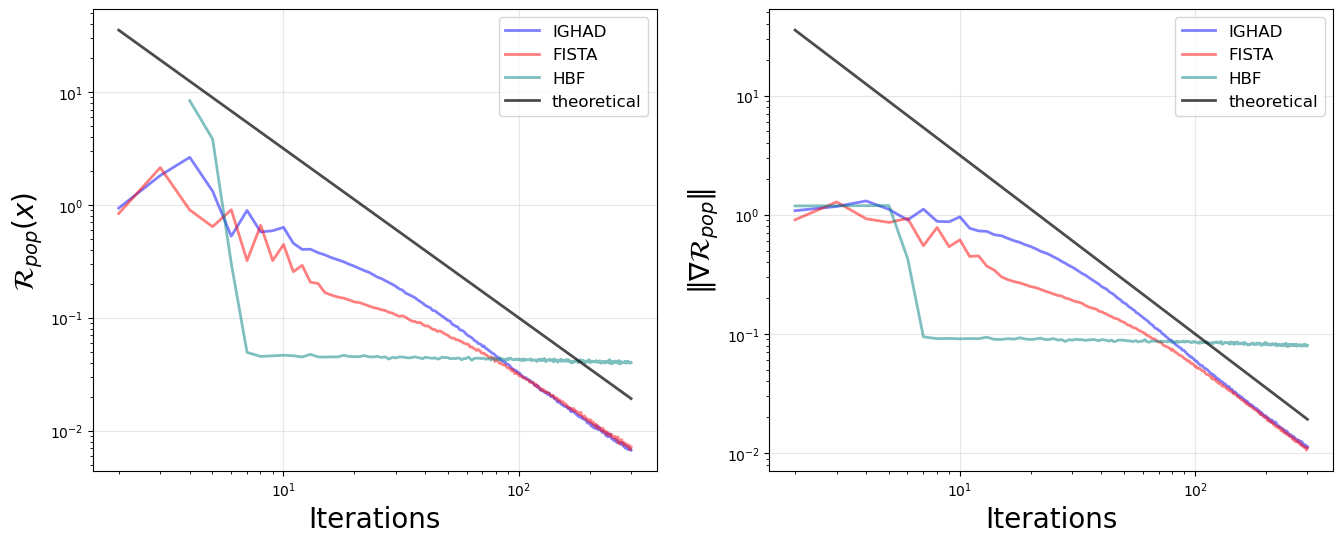

In [35]:
# Plotting results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.linspace(2, iterations, iterations-2)
y = (1/s0)*(1/x**1.5)
dy = (1/np.sqrt(s0))*(1/x**1.25)

axes[0].plot(np.linspace(2, iterations, iterations-2), np.array(pop_losses_ighad)[2:], color='blue', linewidth=2, label='IGHAD', alpha=0.5)
axes[0].plot(np.linspace(2, iterations, iterations-2), np.array(pop_losses_fista)[2:], color='red', linewidth=2, label='FISTA', alpha=0.5)
axes[0].plot(np.linspace(2, iterations, iterations-2), np.array(pop_losses_hbf)[2:], color='teal', linewidth=2, label='HBF', alpha=0.5)
axes[0].plot(x, y, color='black', linewidth=2, label='theoretical', alpha=0.7)
axes[0].set_xlabel('Iterations', fontsize=20)
axes[0].set_ylabel(r'$\mathcal{R}_{pop}(x)$', fontsize=20)
axes[0].legend(fontsize=12, loc = 'upper right')
axes[0].grid(alpha=0.3)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[1].plot(np.linspace(2, iterations, iterations-2), np.abs(np.array(true_grads_ighad)[2:,0]), color='blue', linewidth=2, label='IGHAD', alpha=0.5)
axes[1].plot(np.linspace(2, iterations, iterations-2), np.abs(np.array(true_grads_fista)[2:,0]), color='red', linewidth=2, label='FISTA', alpha=0.5)
axes[1].plot(np.linspace(2, iterations, iterations-2), np.abs(np.array(true_grads_hbf)[2:,0]), color='teal', linewidth=2, label='HBF', alpha=0.5)
axes[1].plot(x, y, color='black', linewidth=2, label='theoretical', alpha=0.7)
axes[1].set_xlabel('Iterations', fontsize=20)
axes[1].set_ylabel(r'$\|\nabla \mathcal{R}_{pop}\|$', fontsize=20)
axes[1].legend(fontsize=12, loc = 'upper right')
axes[1].grid(alpha=0.3)
axes[1].set_yscale('log')
axes[1].set_xscale('log')

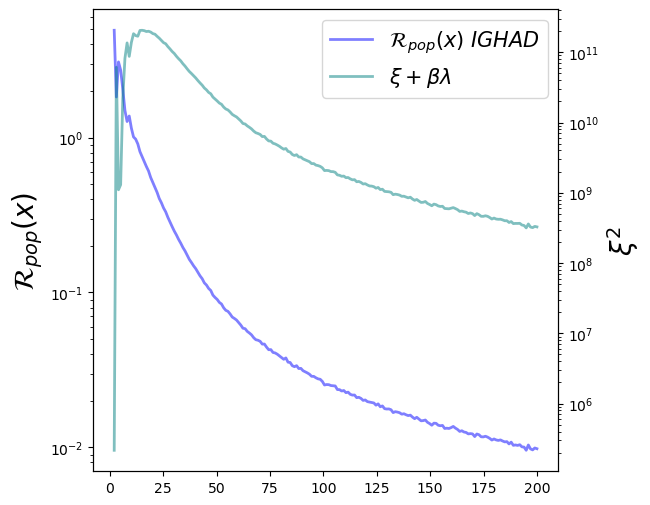

In [ ]:
###### This is utility code for plot in section B.2
###### We used the regression plot there so no need to run it

fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot on the first axis
line1, = ax1.plot(
    np.linspace(2, 200, 198),
    np.array(pop_losses_ighad)[2:],
    color='blue',
    linewidth=2,
    label=r'$\mathcal{R}_{pop}(x)\ IGHAD$',
    alpha=0.5
)
ax1.set_ylabel(r'$\mathcal{R}_{pop}(x)$', fontsize=20)
ax1.set_yscale('log')

# Plot on the second axis
ax2 = ax1.twinx()
line2, = ax2.plot(
    np.linspace(2, 200, 198),
    np.array(xi2_param_list)[1:],
    color='teal',
    linewidth=2,
    label=r'$\xi^2$',
    alpha=0.5
)
ax2.set_ylabel(r'$\xi^2$', fontsize=20)
#ax2.set_ylim(29, 30)

lines = [line1, line2]
labels = [line.get_label() for line in lines]
labels = [r'$\mathcal{R}_{pop}(x)\ IGHAD$', r'$\xi + \beta\lambda$']
ax2.set_yscale('log')
ax1.legend(lines, labels, fontsize=15, loc='upper right')

plt.show()


In [ ]:
###### Code to generate feature plots #####


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Number of features
num_features = 6

# Generate random means and variances for two classes
np.random.seed(42)  # For reproducibility
means_class1 = np.random.uniform(-3, 3, size=5).tolist() + [np.random.uniform(55, 65)]
means_class2 = np.random.uniform(-3, 3, size=5).tolist() + [np.random.uniform(55, 65)]
variances_class1 = np.random.uniform(1, 6, size=5).tolist() + [np.random.uniform(10, 20)]
variances_class2 = np.random.uniform(1, 6, size=5).tolist() + [np.random.uniform(10, 20)]

# Generate additional blobs for features 1, 5, and 6
extra_means_class1 = np.random.uniform(-3, 0, size=5).tolist() + np.random.uniform(0, 3, size=5).tolist()
extra_variances_class1 = np.random.uniform(0, 6, size=10).tolist()
extra_means_class2 = np.random.uniform(55, 60, size=5).tolist() + np.random.uniform(60, 65, size=5).tolist()
extra_variances_class2 = [10] * 10

# Generate data
data = []
for i in range(num_features):
    data.extend([(f'Feature{i+1}', value, 'Class 1') for value in np.random.normal(means_class1[i], np.sqrt(variances_class1[i]), size=10000)])
    data.extend([(f'Feature{i+1}', value, 'Class 2') for value in np.random.normal(means_class2[i], np.sqrt(variances_class2[i]), size=10000)])

# Add extra blobs for Features 1, 5, and 6 for both classes
for i, (mean, var) in enumerate(zip(extra_means_class1, extra_variances_class1)):
    feature = 'Feature1' if i < 5 else 'Feature5'
    data.extend([(feature, value, 'Class 1') for value in np.random.normal(mean, np.sqrt(var), size=10000)])

for i, (mean, var) in enumerate(zip(extra_means_class2, extra_variances_class2)):
    feature = 'Feature6'
    data.extend([(feature, value, 'Class 2') for value in np.random.normal(mean, np.sqrt(var), size=10000)])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Feature", "Value", "Class"])

# Define a muted color palette
colors = sns.color_palette("husl", n_colors=2)

# Plot the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="Feature", y="Value", hue="Class", data=df, linewidth=0.6, palette=colors, scale='width', alpha=0.2, split=True)

# Add vertical lines from top to bottom of the plot
for i in range(num_features):
    plt.axvline(x=i, color='black', linestyle='--', linewidth=0.8, alpha=0.7)

# Extend violins fully
plt.ylim(df["Value"].min() - 5, df["Value"].max() + 5)

#plt.title("Violin Plot of Features with Multiple Blobs for Two Classes", fontsize=14, fontweight='bold')
#plt.xlabel("Features", fontsize=20)
plt.ylabel(r'$\mathbb{{E}}[X]$', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Class", loc="upper left", fontsize=12)
plt.show()